<a href="https://colab.research.google.com/github/Dhairya-Arora01/Cardio-disease-predictor/blob/main/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
data = pd.read_csv('drive/MyDrive/cardio_train.csv', sep=";")

In [5]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


id is of no use

In [6]:
data = data.drop(columns=['id'])

In [7]:
data.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## EDA

In [8]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
print(data[data['ap_hi']<=0]['ap_hi'].count())
print(data[data['ap_lo']<=0]['ap_lo'].count())

7
22


Systolic and Disystolic pressure can't be negative. So need to remove these entries

In [10]:
data[data['ap_hi']<=0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4607,15281,1,165,78.0,-100,80,2,1,0,0,1,0
16021,22108,2,161,90.0,-115,70,1,1,0,0,1,0
20536,15581,1,153,54.0,-100,70,1,1,0,0,1,0
23988,18301,1,162,74.0,-140,90,1,1,0,0,1,1
25240,14711,2,168,50.0,-120,80,2,1,0,0,0,1
35040,23325,2,168,59.0,-150,80,1,1,0,0,1,1
46627,23646,2,160,59.0,-120,80,1,1,0,0,0,0


In [11]:
data = data.drop(data[(data['ap_hi']<=0) | (data['ap_lo']<=0) | (data['ap_hi'] < data['ap_lo'])].index)

In [12]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000
mean,19464.158850,1.348583,164.359857,74.116847,128.775297,81.272795,1.364686,1.225620,0.087877,0.053343,0.803416,0.494821
std,2468.210782,0.476525,8.190841,14.331747,155.059640,9.573730,0.678893,0.571479,0.283118,0.224718,0.397418,0.499977
min,10798.000000,1.000000,55.000000,11.000000,16.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
data['cardio'].value_counts()

0    34728
1    34016
Name: cardio, dtype: int64

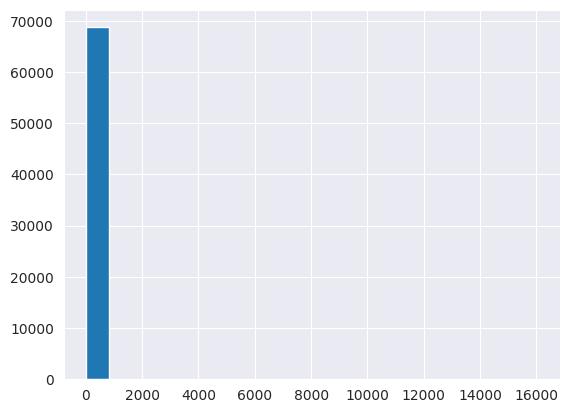

In [14]:
plt.hist(data['ap_hi'], bins=20)
plt.show()

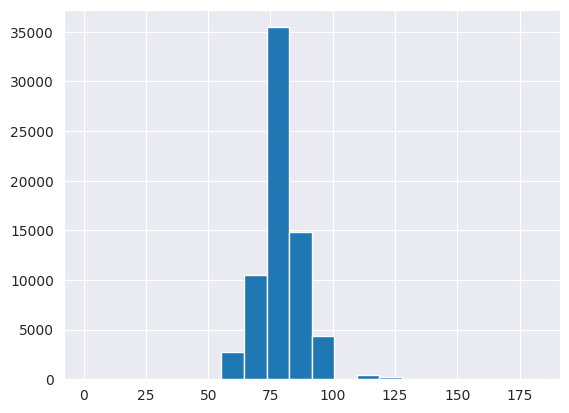

In [15]:
plt.hist(data['ap_lo'], bins=20)
plt.show()

It seems that the data is filled with outliers lets say by plotting box plots for each of the numerical feature

In [16]:
num_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

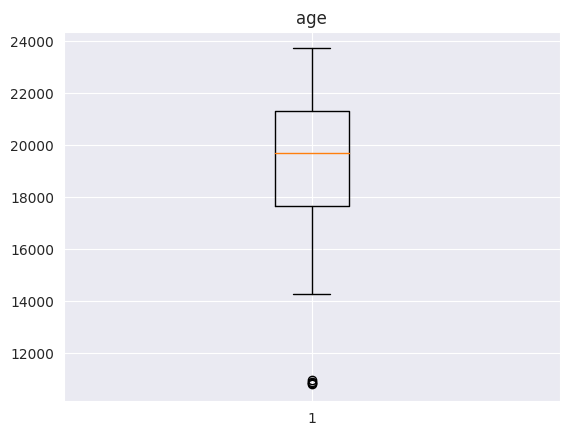

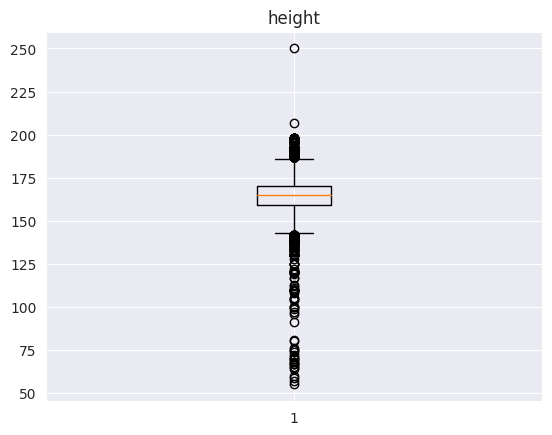

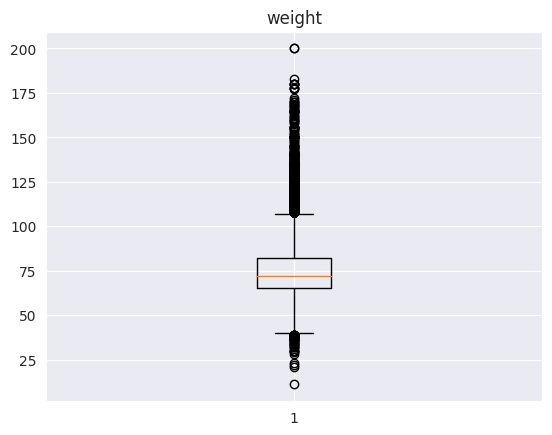

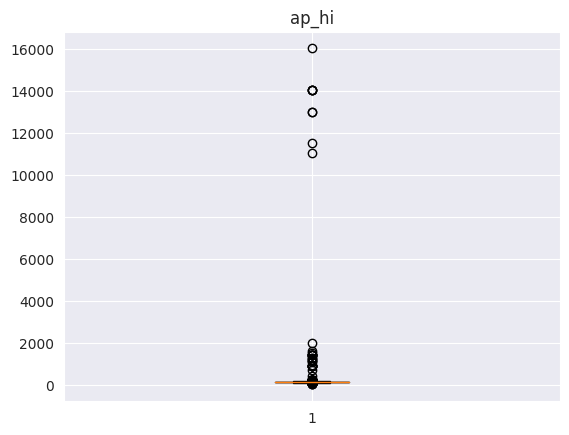

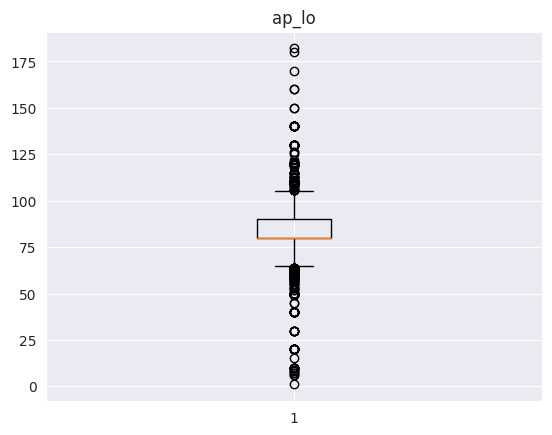

In [17]:
for feature in num_features:
  plt.boxplot(data[feature])
  plt.title(feature)
  plt.show()

Definitely ap_hi and ap_lo values are non-sensical. Lets calculate the z-score and by convention values more or less than 2 and -2 can be considered as outliers.

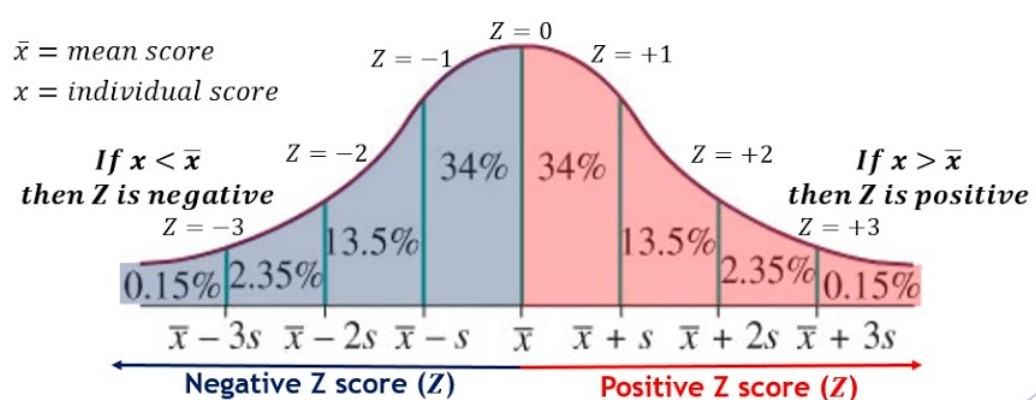

### Removing outliers

In [18]:
data = data[(stats.zscore(data['ap_hi']) > -2) & (stats.zscore(data['ap_hi']) < 2) & (stats.zscore(data['ap_lo']) > -2) & (stats.zscore(data['ap_lo']) < 2)]

In [19]:
data.shape

(65148, 12)

## Preprocessing

In [20]:
y = data['cardio']
X = data.drop(columns=['cardio'])

In [21]:
X

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
5,21914,1,151,67.0,120,80,2,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1
69996,22601,1,158,126.0,140,90,2,2,0,0,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0
69998,22431,1,163,72.0,135,80,1,2,0,0,0


In [22]:
print(X.shape, y.shape)

(65148, 11) (65148,)


### Splitting the data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28)

### Scaling the numerical features

In [31]:
ct = ColumnTransformer([
    ('scaler', MinMaxScaler(), [i for i in range(6)]),
    ('passthrough', 'passthrough', [i for i in range(6, 11)])
])

X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

## Baseline Model

In [35]:
lr = LogisticRegression(random_state=28)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=28)

In [61]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
  print("Training set")
  print(classification_report(y_train, model.predict(X_train)))
  train_plot = ConfusionMatrixDisplay(confusion_matrix(y_train, model.predict(X_train)))
  train_plot.plot()
  plt.show()
  print("----------------")
  print("Test Set")
  print(classification_report(y_test, model.predict(X_test)))
  test_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test)))
  test_plot.plot()
  plt.show()

Training set
              precision    recall  f1-score   support

           0       0.70      0.78      0.74     24256
           1       0.75      0.67      0.71     24605

    accuracy                           0.72     48861
   macro avg       0.73      0.73      0.72     48861
weighted avg       0.73      0.72      0.72     48861



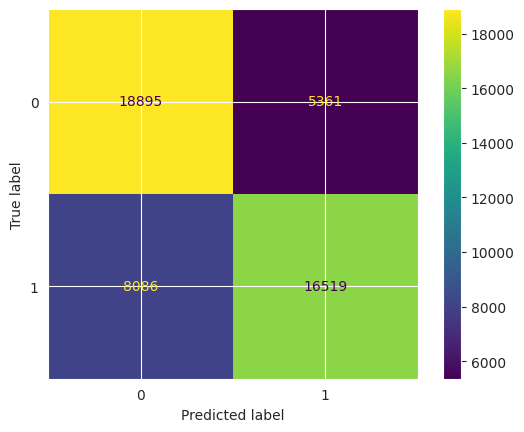

----------------
Test Set
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      8196
           1       0.75      0.67      0.70      8091

    accuracy                           0.72     16287
   macro avg       0.73      0.72      0.72     16287
weighted avg       0.73      0.72      0.72     16287



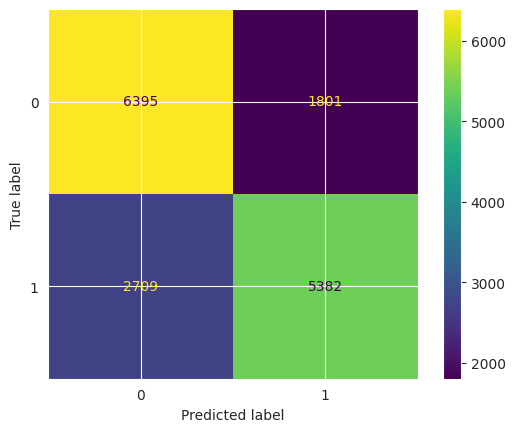

In [62]:
evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)